In [1]:
import random
import numpy as np
from sklearn import datasets
from importlib import reload
import matplotlib.pyplot as plt
import time
import pandas as pd

### Reload modules after changes

In [176]:
import __init__
import distributions
import kernel
import fuzzifier
import optimization

reload(__init__)
reload(distributions)
reload(kernel)
reload(fuzzifier)
reload(optimization)

from __init__ import *
from distributions import *
from kernel import *
from fuzzifier import *
from optimization import *

In [3]:
from mulearn import FuzzyInductor as fz
from mulearn.kernel import LinearKernel as link
from mulearn.fuzzifier import LinearFuzzifier as linf

## Testing

In [3]:
def generate_dataset(n_samples=10, n_features=1):

    #random.seed(42)
    
    X = np.zeros((n_samples, n_features))

    for elem in range(n_samples):
        for dim in range(n_features):
            X[elem][dim] = random.uniform(0,1)

    gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

    y = np.zeros(n_samples)
    
    for elem in range(n_samples):
        y[elem] = 1
        for dim in range(n_features):
            y[elem] *= gaussian(X[elem][dim], np.var([X[j][dim] for j in range(n_samples)]))
                          
    
    return X,y

In [5]:
X,y = generate_dataset(n_samples=100,n_features=1)

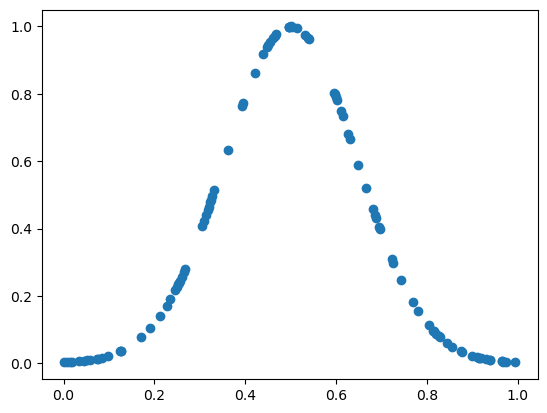

In [77]:
plt.scatter(X,y)
plt.show()

In [213]:
X,y = generate_dataset(n_samples=1500,n_features=1)

In [214]:
model = FuzzyInductor()

In [130]:
s_time = time.time()
model.fit(X=X, y=y)
print("Fit time: ", time.time() - s_time)
print("Dataset size: ", len(X))

Fit time:  59.946744203567505
Dataset size:  1500


In [215]:
print("Vectorized kernel.compute() version")
s_time = time.time()
model.fit(X=X, y=y)
print("Fit time: ", time.time() - s_time)
print("Dataset size: ", len(X))

Vectorized kernel.compute() version
Fit time:  26.57704782485962
Dataset size:  1500


In [131]:
model2 = fz() #original mulearn

In [132]:
s_time = time.time()
model2.fit(X=X, y=y)
print("Fit time: ", time.time() - s_time)
print("Dataset size: ", len(X))

Fit time:  81.94515299797058
Dataset size:  1500


In [216]:
X_test,_ = generate_dataset(1000)

In [219]:
s = time.time()
r = list(map(lambda X:float((np.dot(X, X) + 1) ** 5), X_test))
f = time.time()
print(r)
print("time: ", f - s)

[1.0748271073603626, 31.783639010822498, 21.56973106038076, 2.9070131229006875, 1.6343949742123238, 2.698610860821274, 1.0073698978534649, 14.283455465484847, 5.910689538170704, 1.0285379540668003, 11.953933237521273, 3.2920185906011987, 19.994836518079854, 1.7218406718379513, 13.478107502644761, 1.0312349541094017, 2.773464227129915, 4.955585389154663, 12.159590569566268, 9.440498367552523, 26.03679669280488, 1.462446946143966, 21.27551469346535, 5.589605683529933, 5.439076432596421, 6.991797647440891, 8.766891871058068, 1.2411871003317125, 3.796140205251615, 5.677224231233065, 23.30395198650088, 1.7090737136067395, 8.086432303244422, 13.011133726119896, 1.0122149706844938, 1.0417644189161848, 26.931974059774983, 4.449908550543069, 16.028335582945623, 31.007215150359105, 15.606845178056231, 1.1763394015865043, 1.544591424775722, 8.920292910770238, 1.0178479713955948, 1.1347960942431297, 8.881226622642169, 10.049854800426706, 16.555972640641915, 1.6191856966278548, 1.193007305214969, 1

In [220]:
s = time.time()
r = (np.sum(X_test * X_test, axis=1)+1)**5
f = time.time()
print(r)
print("time: ", f - s)

[ 1.07482711 31.78363901 21.56973106  2.90701312  1.63439497  2.69861086
  1.0073699  14.28345547  5.91068954  1.02853795 11.95393324  3.29201859
 19.99483652  1.72184067 13.4781075   1.03123495  2.77346423  4.95558539
 12.15959057  9.44049837 26.03679669  1.46244695 21.27551469  5.58960568
  5.43907643  6.99179765  8.76689187  1.2411871   3.79614021  5.67722423
 23.30395199  1.70907371  8.0864323  13.01113373  1.01221497  1.04176442
 26.93197406  4.44990855 16.02833558 31.00721515 15.60684518  1.1763394
  1.54459142  8.92029291  1.01784797  1.13479609  8.88122662 10.0498548
 16.55597264  1.6191857   1.19300731 13.53187374 12.61172973  4.59838459
 23.64802157  1.10521194  5.59533253  6.59088907 10.19368392  1.91867768
  9.01954852  1.22659489  1.77000088  1.11395566  2.76021538 13.40676141
  1.02759079  3.79119892  3.9157743   1.083403    2.64266268  1.09837941
  1.57900282 25.64557924 31.57207029  2.14525573  1.010318    5.2312142
 16.53597845 12.93623143  5.43332701  5.78225924  2.77

## Fuzzifier testing

### Trapezoidal

In [406]:
def generate_dataset_trapezoidal(n_samples=10, n_features=1):

    #random.seed(42)
    
    X = np.zeros((n_samples, n_features))

    for elem in range(n_samples):
        for dim in range(n_features):
            X[elem][dim] = random.uniform(0,1)

    trapezoidal = lambda x: (3*x if x < 0.5 else -3*x+3) if (3*x if x < 0.5 else -3*x+3) < 1 else 1

    y = np.zeros(n_samples)
    
    for elem in range(n_samples):
        y[elem] = 1
        for dim in range(n_features):
            y[elem] *= trapezoidal(X[elem][dim])
                          
    
    return X,y

In [456]:
trapezoidal = lambda x: (3*x if x < 0.5 else -3*x+3) if (3*x if x < 0.5 else -3*x+3) < 1 else 1
X, y = generate_dataset_trapezoidal(500)
X_new = np.linspace(0, 1, 1000).reshape(-1, 1)
y_new = np.array(list(map(trapezoidal, X_new)))

In [457]:
model = FuzzyInductor(k=GaussianKernel(sigma=0.1),fuzzifier=ExponentialFuzzifier(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [458]:
model.fit(X, y)

FuzzyInductor(c=1, k=GaussianKernel(sigma=0.1), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=auto))

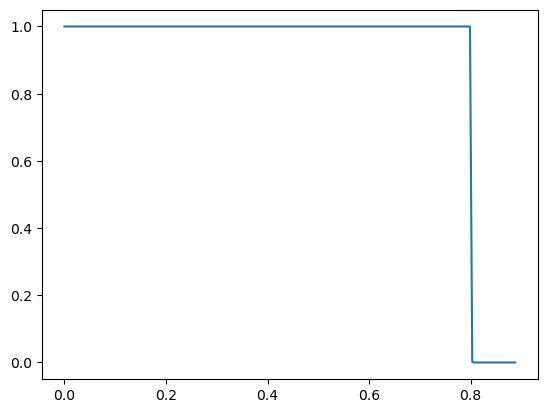

In [459]:
plt.plot(model.fuzzifier.get_profile(X)[1],model.fuzzifier.get_profile(X)[2])
plt.show()

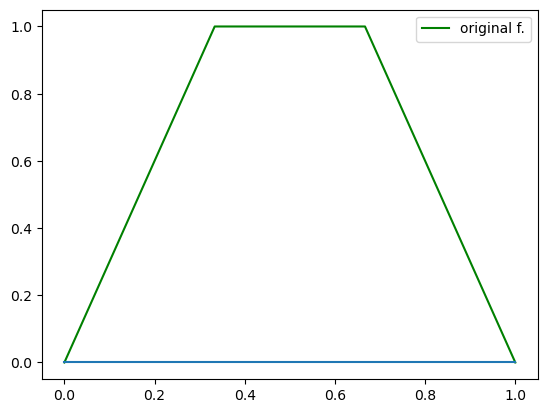

In [460]:
y_pred = model.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred)
plt.legend(loc="upper right")
plt.show()

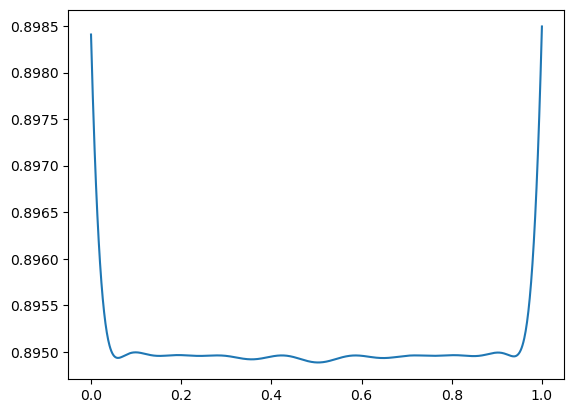

In [461]:
X_dist = list(map(model.fuzzifier.x_to_sq_dist,X_new))
X_dist = list(map(lambda x:x**0.5, X_dist))
y_memb = list(map(model.fuzzifier.r_to_mu, X_dist))

plt.plot(X_new, X_dist)
plt.show()

In [462]:
model = FuzzyInductor(k=GaussianKernel(sigma=0.1),fuzzifier=ExponentialFuzzifierMOD(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [463]:
model.fit(X, y)

FuzzyInductor(c=1, k=GaussianKernel(sigma=0.1), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=auto))

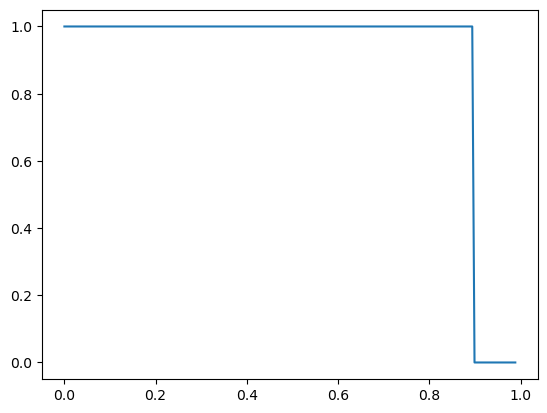

In [464]:
plt.plot(model.fuzzifier.get_profile(X)[1],model.fuzzifier.get_profile(X)[2])
plt.show()

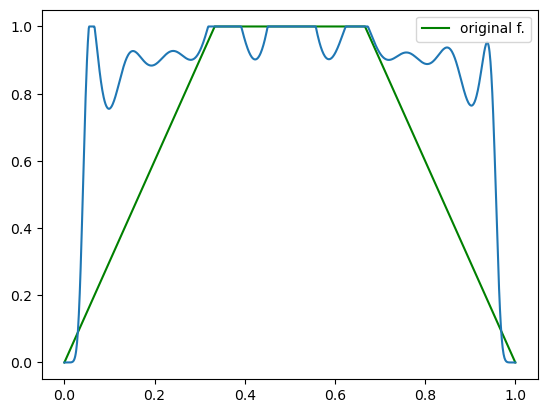

In [465]:
y_pred = model.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred)
plt.legend(loc="upper right")
plt.show()

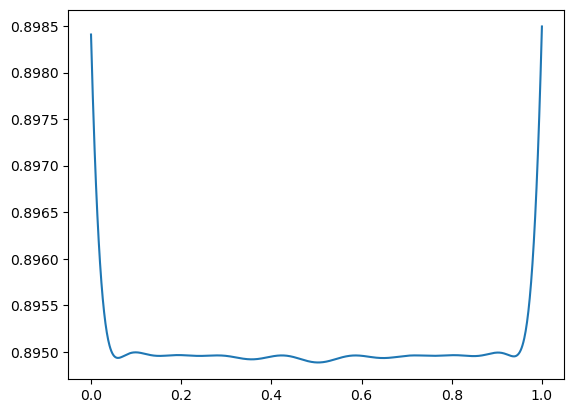

In [466]:
X_dist = list(map(model.fuzzifier.x_to_sq_dist,X_new))
X_dist = list(map(lambda x:x**0.5, X_dist))
y_memb = list(map(model.fuzzifier.r_to_mu, X_dist))

plt.plot(X_new, X_dist)
plt.show()

In [467]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=LinearFuzzifier(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [468]:
model.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=auto))

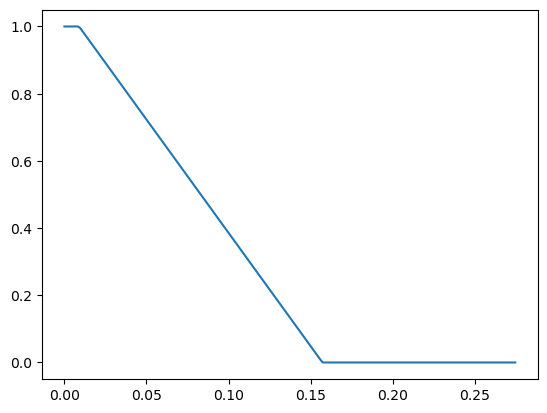

In [469]:
plt.plot(model.fuzzifier.get_profile(X)[1],model.fuzzifier.get_profile(X)[2])
plt.show()

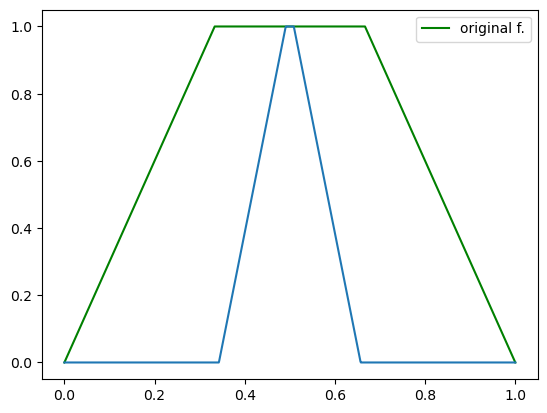

In [470]:
y_pred = model.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred)
plt.legend(loc="upper right")
plt.show()

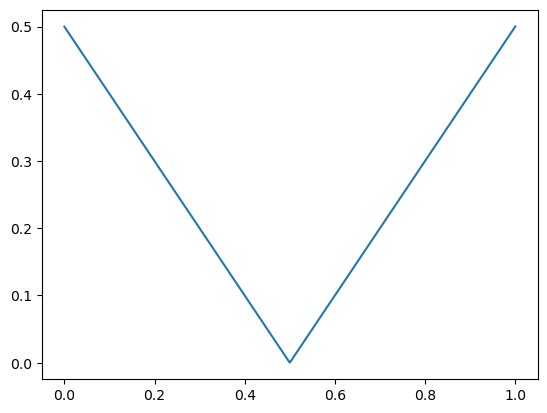

In [471]:
X_dist = list(map(model.fuzzifier.x_to_sq_dist,X_new))
X_dist = list(map(lambda x:x**0.5, X_dist))
y_memb = list(map(model.fuzzifier.r_to_mu, X_dist))

plt.plot(X_new, X_dist)
plt.show()

In [473]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=LinearFuzzifierMOD(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [474]:
model.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=auto))

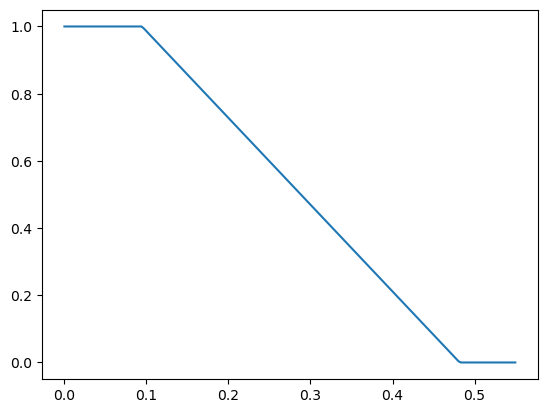

In [475]:
plt.plot(model.fuzzifier.get_profile(X)[1],model.fuzzifier.get_profile(X)[2])
plt.show()

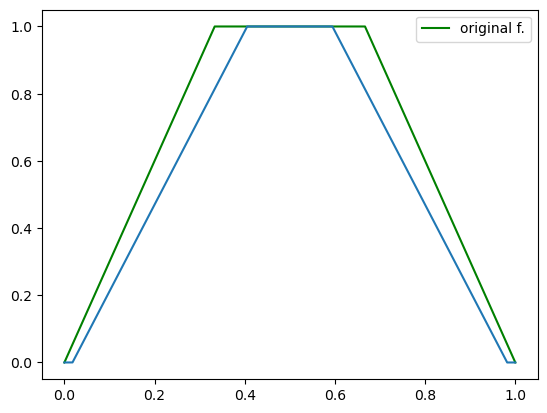

In [476]:
y_pred = model.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred)
plt.legend(loc="upper right")
plt.show()

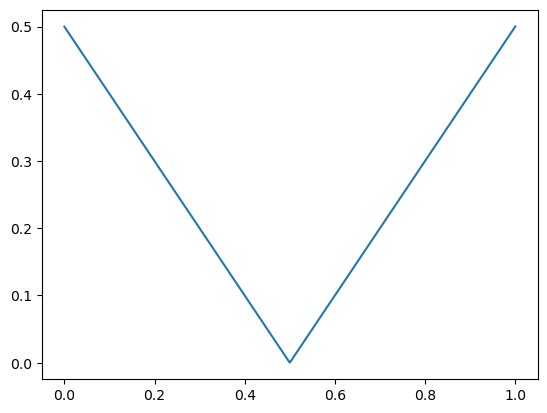

In [477]:
X_dist = list(map(model.fuzzifier.x_to_sq_dist,X_new))
X_dist = list(map(lambda x:x**0.5, X_dist))
y_memb = list(map(model.fuzzifier.r_to_mu, X_dist))

plt.plot(X_new, X_dist)
plt.show()

### Gaussian

In [274]:
def generate_dataset(n_samples=10, n_features=1):

    #random.seed(42)
    
    X = np.zeros((n_samples, n_features))

    for elem in range(n_samples):
        for dim in range(n_features):
            X[elem][dim] = random.uniform(0,1)

    gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

    y = np.zeros(n_samples)
    
    for elem in range(n_samples):
        y[elem] = 1
        for dim in range(n_features):
            y[elem] *= gaussian(X[elem][dim], np.var([X[j][dim] for j in range(n_samples)]))
                          
    
    return X,y

In [275]:
gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))
X, y = generate_dataset(500)
X_new = np.linspace(0, 1, 1000).reshape(-1, 1)
y_new = gaussian(X_new, var=np.var(X_new))

In [485]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=CrispFuzzifier(profile='fixed'),solver=GurobiSolver(adjustment='auto'))
model2 = FuzzyInductor(k=LinearKernel(),fuzzifier=CrispFuzzifierMOD(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [486]:
model.fit(X, y)
model2.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=CrispFuzzifier(), solver=GurobiSolver(, adjustment=auto))

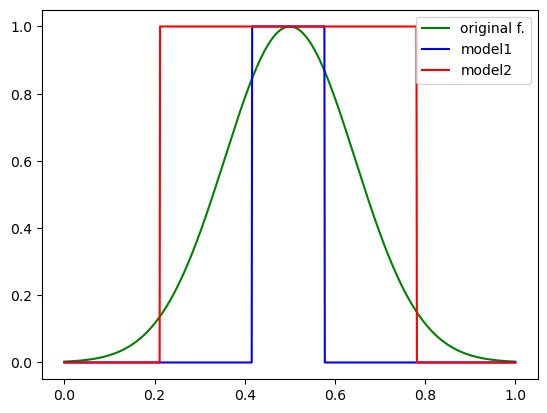

In [487]:
y_pred_1 = model.predict(X_new)
y_pred_2 = model2.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred_1, color='blue', label="model1")
plt.plot(X_new, y_pred_2, color='red', label="model2")
plt.legend(loc="upper right")
plt.show()

In [488]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=LinearFuzzifier(profile='fixed'),solver=GurobiSolver(adjustment='auto'))
model2 = FuzzyInductor(k=LinearKernel(),fuzzifier=LinearFuzzifierMOD(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [489]:
model.fit(X, y)
model2.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=auto))

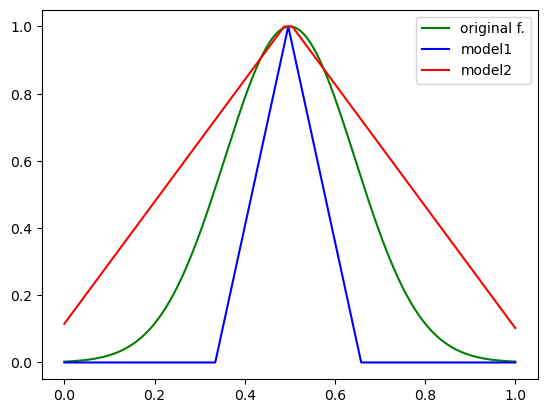

In [490]:
y_pred_1 = model.predict(X_new)
y_pred_2 = model2.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred_1, color='blue', label="model1")
plt.plot(X_new, y_pred_2, color='red', label="model2")
plt.legend(loc="upper right")
plt.show()

In [491]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=ExponentialFuzzifier(profile='fixed'),solver=GurobiSolver(adjustment='auto'))
model2 = FuzzyInductor(k=LinearKernel(),fuzzifier=ExponentialFuzzifierMOD(profile='fixed'),solver=GurobiSolver(adjustment='auto'))

In [492]:
model.fit(X, y)
model2.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=auto))

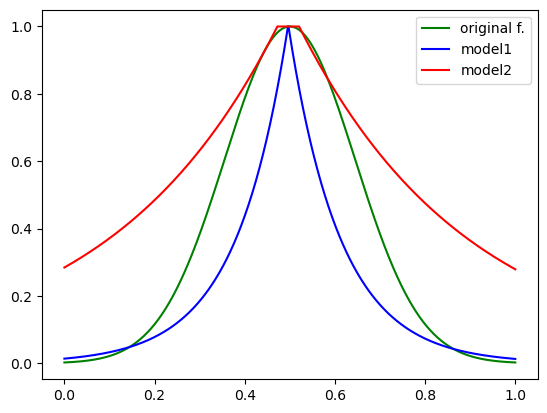

In [493]:
y_pred_1 = model.predict(X_new)
y_pred_2 = model2.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred_1, color='blue', label="model1")
plt.plot(X_new, y_pred_2, color='red', label="model2")
plt.legend(loc="upper right")
plt.show()

In [495]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=QuantileConstantPiecewiseFuzzifier(),solver=GurobiSolver(adjustment='auto'))
model2 = FuzzyInductor(k=LinearKernel(),fuzzifier=QuantileConstantPiecewiseFuzzifierMOD(),solver=GurobiSolver(adjustment='auto'))

In [496]:
model.fit(X, y)
model2.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=QuantileConstantPiecewiseFuzzifier(), solver=GurobiSolver(, adjustment=auto))

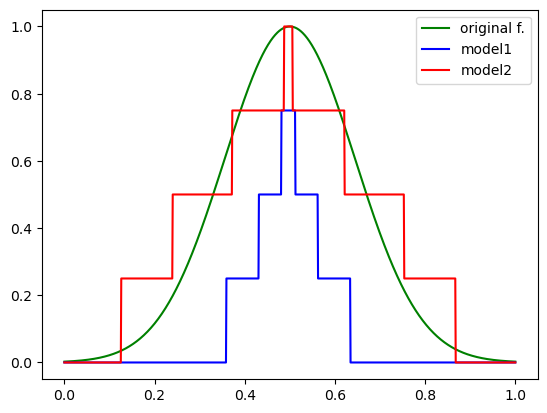

In [497]:
y_pred_1 = model.predict(X_new)
y_pred_2 = model2.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred_1, color='blue', label="model1")
plt.plot(X_new, y_pred_2, color='red', label="model2")
plt.legend(loc="upper right")
plt.show()

In [498]:
model = FuzzyInductor(k=LinearKernel(),fuzzifier=QuantileLinearPiecewiseFuzzifier(),solver=GurobiSolver(adjustment='auto'))
model2 = FuzzyInductor(k=LinearKernel(),fuzzifier=QuantileLinearPiecewiseFuzzifierMOD(),solver=GurobiSolver(adjustment='auto'))

In [499]:
model.fit(X, y)
model2.fit(X, y)

FuzzyInductor(c=1, k=LinearKernel(), f=QuantileLinearPiecewiseFuzzifier(), solver=GurobiSolver(, adjustment=auto))

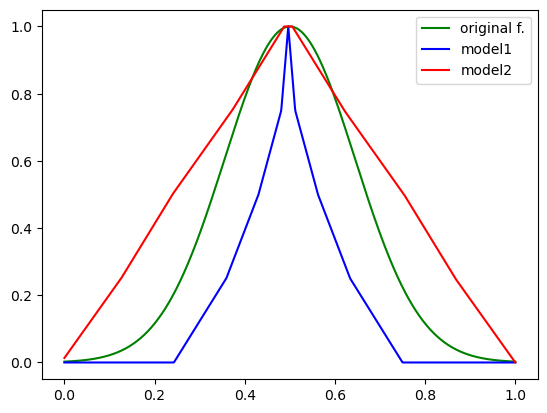

In [500]:
y_pred_1 = model.predict(X_new)
y_pred_2 = model2.predict(X_new)

plt.plot(X_new, y_new, color='green', label="original f.")
plt.plot(X_new, y_pred_1, color='blue', label="model1")
plt.plot(X_new, y_pred_2, color='red', label="model2")
plt.legend(loc="upper right")
plt.show()

## Cooper testing

In [61]:
X, mus = generate_dataset(1000)

In [74]:
model_cooper = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(),\
                             solver=CooperSolver(atol=0.01,n_iter=5000,lr=1e-3, device='cpu'))
model_gurobi = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(), solver=GurobiSolver())

In [75]:
model_cooper

FuzzyInductor(c=1, k=GaussianKernel(), f=ExponentialFuzzifier(), solver=CooperSolver(, n_iter=5000, atol=0.01))

In [76]:
s = time.time()
model_cooper.fit(X, mus)
print("time:", time.time()-s)

time: 25.542489290237427


In [77]:
s = time.time()
model_gurobi.fit(X, mus)
print("time:", time.time()-s)

time: 26.0446355342865


In [78]:
kern = GaussianKernel()
k = np.array([[kern.compute(x1, x2) for x1 in X] for x2 in X])

chis_c = np.array(model_cooper.chis_)
chis_g = np.array(model_gurobi.chis_)

print('cooper solution:', -chis_c.dot(np.diag(k)) + chis_c.dot(k.dot(chis_c)))
print('gurobi solution:', -chis_g.dot(np.diag(k)) + chis_g.dot(k.dot(chis_g)))

cooper solution: -0.34285741629405386
gurobi solution: -0.37322491455810347


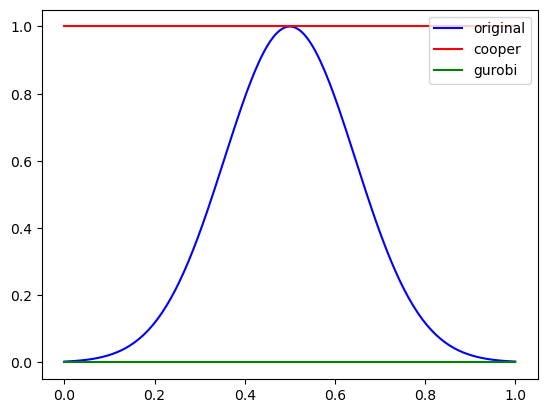

In [79]:
gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

X_new = np.linspace(0, 1, 200).reshape(-1, 1)
y_new = gaussian(X_new, var=np.var(X_new))

y_pred_cooper = model_cooper.predict(X_new)
y_pred_gurobi = model_gurobi.predict(X_new)

plt.plot(X_new, y_new, color='blue', label="original")
plt.plot(X_new, y_pred_cooper, color='red',  label="cooper")
plt.plot(X_new, y_pred_gurobi, color='green', label="gurobi")
plt.legend(loc="upper right")
plt.show()

In [274]:
X, mus = generate_dataset(5000)

In [81]:
model_cooper = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(),\
                             solver=CooperSolver(atol=0.01,n_iter=5000,lr=1e-3, device='gpu'))
s = time.time()
model_cooper.fit(X, mus)
print("time:", time.time()-s)

cooper: optimal values not found


time: 605.8112759590149


In [82]:
model_gurobi = FuzzyInductor(c=1,k=GaussianKernel(), fuzzifier=ExponentialFuzzifier(),\
                             solver=GurobiSolver())
s = time.time()
model_gurobi.fit(X, mus)
print("time:", time.time()-s)

time: 641.4228239059448


In [276]:
kern = GaussianKernel()
s = time.time()
k = [[kern.compute(x1, x2) for x1 in X] for x2 in X]
print('time:', time.time() - s)

time: 141.54320216178894


## Fuzzy set shape testing

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import PredefinedSplit



kernels_d = {'linear' : [LinearKernel()],
             
             'polynomial' : [PolynomialKernel(2),\
                             PolynomialKernel(3),\
                             PolynomialKernel(4),\
                             PolynomialKernel(5)],
             
             'homogeneous_polynomial' : [HomogeneousPolynomialKernel(2), HomogeneousPolynomialKernel(3),\
                                         HomogeneousPolynomialKernel(4), HomogeneousPolynomialKernel(5)],
             
             'gaussian' : [GaussianKernel(1), GaussianKernel(0.5), GaussianKernel(0.1), GaussianKernel(0.05)],
             
             'hyperbolic' : [HyperbolicKernel(scale=1,offset=0), HyperbolicKernel(scale=1,offset=1),\
                             HyperbolicKernel(scale=0.5,offset=0), HyperbolicKernel(scale=0.5,offset=1),\
                             HyperbolicKernel(scale=2,offset=0), HyperbolicKernel(scale=2,offset=1)]}

fuzzifiers_d = {'crisp' : [CrispFuzzifier(profile='fixed'),\
                           CrispFuzzifier(profile='infer')],
                
                'linear' : [LinearFuzzifier(profile='fixed'),\
                            LinearFuzzifier(profile='infer')],
                
                'exponential' : [ExponentialFuzzifier(profile='fixed'), ExponentialFuzzifier(profile='infer'),\
                                 ExponentialFuzzifier(profile='alpha', alpha=2),\
                                 ExponentialFuzzifier(profile='alpha', alpha=1),\
                                 ExponentialFuzzifier(profile='alpha', alpha=0.5),\
                                 ExponentialFuzzifier(profile='alpha', alpha=0.05)],
                
                'quantile_constant' : [QuantileConstantPiecewiseFuzzifier()],
                
                'quantile_linear' : [QuantileLinearPiecewiseFuzzifier()]}

kernels = ['linear', 'polynomial', 'homogeneous_polynomial', 'gaussian', 'hyperbolic']
fuzzifiers = ['crisp', 'linear', 'exponential', 'quantile_constant', 'quantile_linear']

X, y = generate_dataset(n_samples=1000, n_features=1)

X, y = pd.DataFrame(X), pd.DataFrame(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8)
split_index = [-1 if x in X_train.index else 0 for x in X.index]
pds = PredefinedSplit(test_fold = split_index)

X_new = np.linspace(0, 1, 200).reshape(-1, 1)

gridx, gridy = 25, 1
k = 1

plt.figure(figsize=(3, 100))

for kernel in kernels:
    for fuzzifier in fuzzifiers:

        params = {'c' : [0.01, 0.1, 1],
                  'k' : kernels_d[kernel],
                  'fuzzifier' : fuzzifiers_d[fuzzifier],
                  'solver' : [GurobiSolver(adjustment='auto')]}

        
        model = FuzzyInductor()

        clf = GridSearchCV(estimator=model, cv=pds, param_grid=params, n_jobs=-1) 
        clf.fit(X, np.ravel(y))
    

        clf.best_estimator_.fit(X_train, np.ravel(y_train))

        font = {'size' : 7}
        
        plt.subplot(gridx,gridy,k)
        plt.title(clf.best_estimator_.__repr__(), fontdict=font)
        plt.plot(X_new, clf.best_estimator_.predict(X_new), color='green')

        gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

        plt.plot(X_new, gaussian(X_new, np.var(X_new)))
        
        k+=1

plt.show()



### Gaussian membership

In [197]:
model = FuzzyInductor(c=0.007, k=GaussianKernel(sigma=0.5), fuzzifier=ExponentialFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [198]:
X, y = generate_dataset(500)

In [199]:
model.fit(X,y)

FuzzyInductor(c=0.007, k=GaussianKernel(sigma=0.5), f=ExponentialFuzzifier(), solver=GurobiSolver(, adjustment=0))

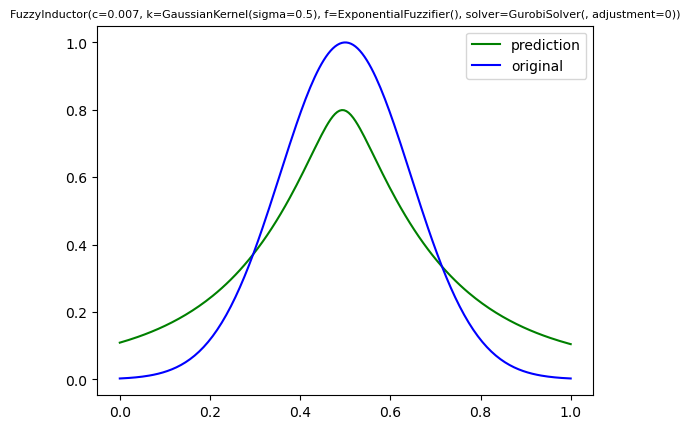

In [200]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

In [201]:
model = FuzzyInductor(c=0.01, k=GaussianKernel(sigma=0.5), fuzzifier=LinearFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [202]:
X, y = generate_dataset(500)

In [203]:
model.fit(X,y)

FuzzyInductor(c=0.01, k=GaussianKernel(sigma=0.5), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=0))

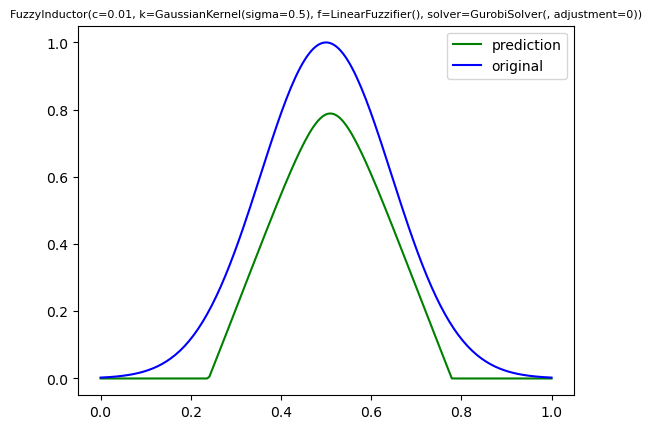

In [204]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

### Triangular membership

In [205]:
model = FuzzyInductor(c=1, k=LinearKernel(), fuzzifier=LinearFuzzifier(profile='fixed'),\
                      solver=GurobiSolver(adjustment='auto'))

In [206]:
X, y = generate_dataset(500)

In [207]:
model.fit(X,y)

FuzzyInductor(c=1, k=LinearKernel(), f=LinearFuzzifier(), solver=GurobiSolver(, adjustment=0))

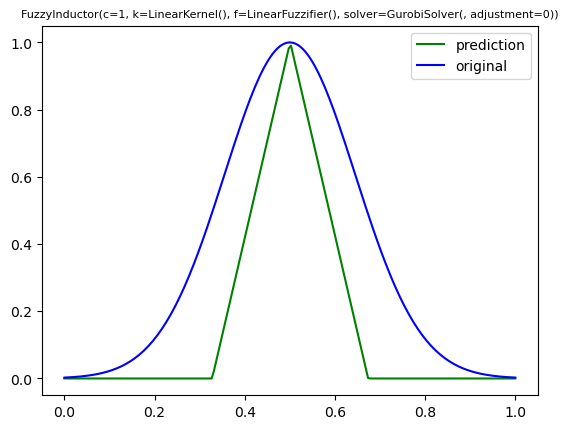

In [208]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

### Rectangular membership

In [193]:
model = FuzzyInductor(c=0.01, k=PolynomialKernel(degree=2), fuzzifier=CrispFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [194]:
X, y = generate_dataset(500)

In [195]:
model.fit(X,y)

FuzzyInductor(c=0.01, k=PolynomialKernel(2), f=CrispFuzzifier(), solver=GurobiSolver(, adjustment=0))

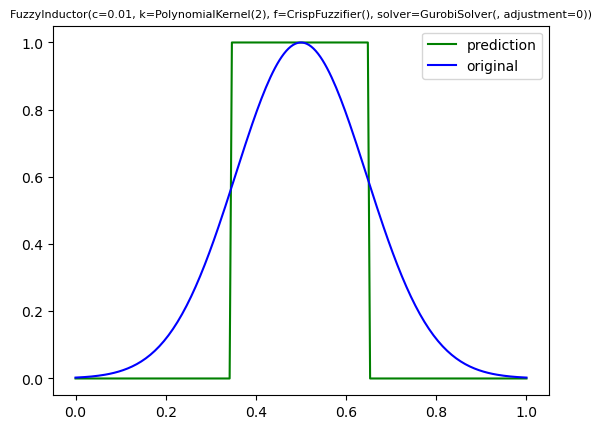

In [196]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()

### "Trapezoidal" membership (?)

In [265]:
model = FuzzyInductor(c=0.1, k=GaussianKernel(sigma=0.1), fuzzifier=QuantileLinearPiecewiseFuzzifier(),\
                      solver=GurobiSolver(adjustment='auto'))

In [266]:
X, y = generate_dataset(500)

In [267]:
model.fit(X,y)

FuzzyInductor(c=0.1, k=GaussianKernel(sigma=0.1), f=QuantileLinearPiecewiseFuzzifier(), solver=GurobiSolver(, adjustment=0))

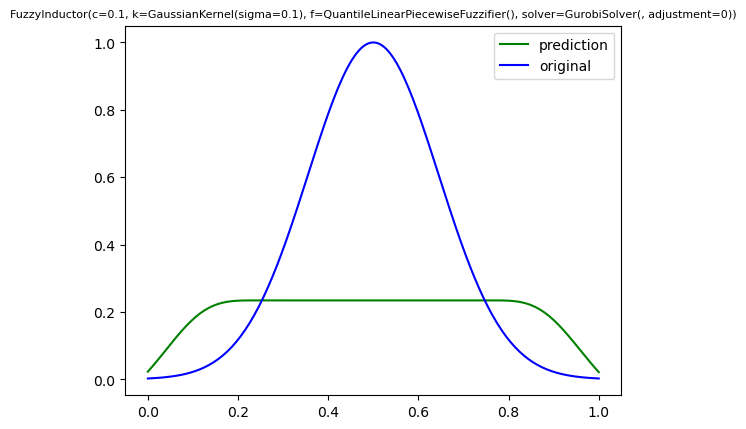

In [268]:
plt.title(model.__repr__(), fontdict={'size' : 8})
plt.plot(X_new, model.predict(X_new), color='green', label='prediction')

gaussian = lambda x,var : (np.e ** (-(((x-0.5)*2)**2)/(2*var)))

plt.plot(X_new, gaussian(X_new, np.var(X_new)), color='blue', label='original')
plt.legend(loc="upper right")
plt.show()